In [1]:
import glob    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

from solardatatools import DataHandler
from solardatatools.solar_noon import energy_com
from solardatatools.signal_decompositions import l2_l1d1_l2d2p365 as cvx_sd # sum_squares version
from solardatatools.signal_decompositions_l2norm import l2_l1d1_l2d2p365 as cvx_sd_l2norm
from solardatatools.algorithms.time_shifts import TimeShift

In [2]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
# plot_heatmap(matrix='raw', flag='clear')
# plot_heatmap(matrix='filled', flag='bad')

# Check current time shift analysis in DataHandler 
# but manually fixing C1 weight from l2 norm optimization
## Cassandra datasets

# Get current decompositions and best c1s

In [4]:
paths = ["./cassandra/timeshifts/*.csv"]

best_c1s_dict = {}
l2_decomp = {}

true_list = []
for path in paths:
    for fname in glob.glob(path):
        print(fname)
        df = pd.read_csv(fname)
        
        from solardatatools import DataHandler
        dh = DataHandler(df, convert_to_ts=True)
        dh.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=True, solver="MOSEK")
        #dh.plot_time_shift_analysis_results()
        #plt.show()
        print(f"Timeshift: ", dh.time_shifts)
        
        if dh.time_shifts:
            true_list.append(fname)
            best_c1s_dict[fname] = dh.time_shift_analysis.best_c1
            l2_decomp[fname] = (dh.time_shift_analysis.s1, dh.time_shift_analysis.s2)

./cassandra/timeshifts/TABF01017766.csv
Sunrise/sunset detection failed.
Matrix filling failed.


Traceback (most recent call last):
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/data_handler.py", line 272, in run_pipeline
    ss.run_optimizer(self.raw_data_matrix, plot=False, solver=solver)
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/algorithms/sunrise_sunset_estimation.py", line 232, in run_optimizer
    ss_smoothed = tl1_l2d2p365(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/signal_decompositions.py", line 215, in tl1_l2d2p365
    problem.solve(solver=solver, verbose=verbose)
  File "/Users/smiskov/opt/anaconda3/envs/pvi-dev-sara/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 493, in solve
    return solve_func(self, *args, **kwargs)
  File "/Users/smiskov/opt/anaconda3/envs/pvi-dev-sara/lib/python3.10/site-packages/cvxpy/problems/problem.py", line 1054, in _solve
    data, solving_chain, inverse_data = self.get_problem_data(
  File "/Users/smiskov/opt/anaconda

Clear day detection failed.


Traceback (most recent call last):
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/data_handler.py", line 364, in run_pipeline
    self.detect_clear_days(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/data_handler.py", line 986, in detect_clear_days
    clear_days = find_clear_days(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/clear_day_detection.py", line 46, in find_clear_days
    y = tl1_l2d2p365(tc, tau=0.9, c1=1e3, yearly_periodic=False, solver=solver)
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/signal_decompositions.py", line 204, in tl1_l2d2p365
    r = signal[use_ixs] - x[use_ixs]
  File "/Users/smiskov/opt/anaconda3/envs/pvi-dev-sara/lib/python3.10/site-packages/cvxpy/expressions/expression.py", line 745, in __array_ufunc__
    return ufunc_handler(self, args[0])
  File "/Users/smiskov/opt/anaconda3/envs/pvi-dev-sara/lib/python3.10/site-packa

ValueError: Invalid dimensions (0,).

In [5]:
print(true_list)

['./cassandra/timeshifts/TABF01017766.csv', './cassandra/timeshifts/TACLC1036521.csv', './cassandra/timeshifts/TABGC1044151.csv', './cassandra/timeshifts/TABB01125140.csv', './cassandra/timeshifts/TABA01148025.csv', './cassandra/timeshifts/TACHC1020772.csv', './cassandra/timeshifts/TACHC1022171.csv', './cassandra/timeshifts/TACHC1022158.csv', './cassandra/timeshifts/TACIC1066981.csv', './cassandra/timeshifts/TAEAC1031314.csv', './cassandra/timeshifts/TADBC1077912.csv', './cassandra/timeshifts/TAAJ01021775.csv', './cassandra/timeshifts/TAEHC1001689.csv', './cassandra/timeshifts/TABD01110568.csv']


# Optimize C2 

### Good region for c2 with sumsquares looks like 1e4 to 1e6

In [6]:
results = {}

In [9]:
weight_iter = np.logspace(2, 4.4, 12) # original c2=500

def run(sig):
    mae_list_s1 = []
    mae_list_s2 = []
    
    df = pd.read_csv(sig)
    for w in tqdm(weight_iter):
        from solardatatools import DataHandler
        dh2 = DataHandler(df, convert_to_ts=True)
        dh2.l2norm = False 
        dh2.run_pipeline(power_col=dh2.keys[0][-1], fix_shifts=True, verbose=False, c2=w, solver="MOSEK")
        # print(dh2.time_shifts)
        # dh2.plot_time_shift_analysis_results()
        # plt.show()

        mae_list_s1.append(mae(dh2.time_shift_analysis.s1, l2_decomp[sig][0]))
        mae_list_s2.append(mae(dh2.time_shift_analysis.s2, l2_decomp[sig][1]))
        
    return weight_iter[np.argmin(mae_list_s1)], np.min(mae_list_s1), mae_list_s1, \
weight_iter[np.argmin(mae_list_s2)], np.min(mae_list_s2), mae_list_s2

TABF01017766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:00<00:00, 25.08s/it]


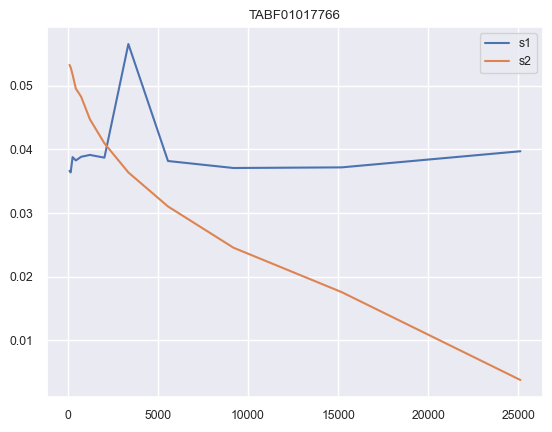

TACLC1036521


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:18<00:00, 21.53s/it]


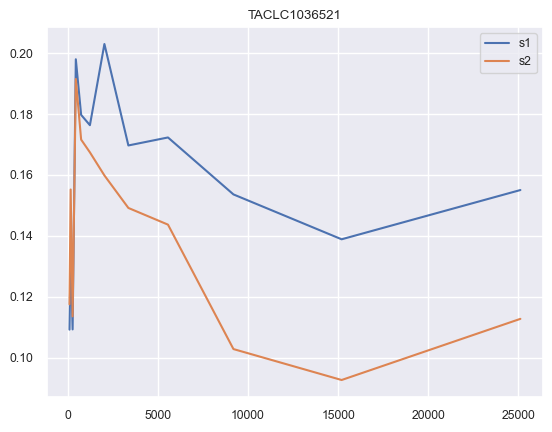

TABGC1044151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:10<00:00, 15.91s/it]


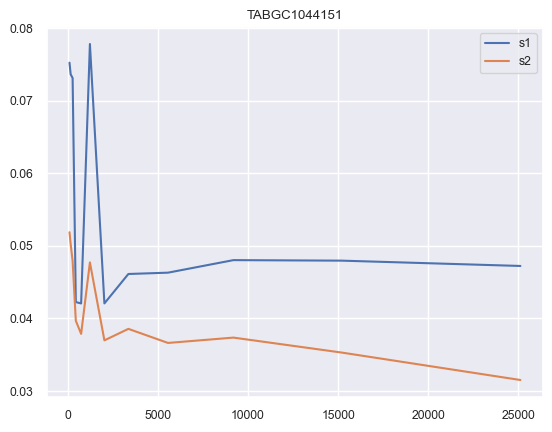

TABB01125140


  0%|                                                                                                                                                                                               | 0/12 [00:12<?, ?it/s]


TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

In [10]:
for path in true_list:
    print(path[23:-4])
    r = run(path)
    
    results[f"{path}_weight_min_s1"] =  r[0]
    results[f"{path}_mae_min_s1"] = r[1]
    results[f"{path}_mae_list_s1"] = r[2]
    
    results[f"{path}_weight_min_s2"] =  r[3]
    results[f"{path}_mae_min_s2"] = r[4]
    results[f"{path}_mae_list_s2"] = r[5]
    
    plt.plot(weight_iter, results[f"{path}_mae_list_s1"], label="s1")
    plt.plot(weight_iter, results[f"{path}_mae_list_s2"], label="s2")
    plt.legend()
    plt.title(path[23:-4])
    plt.show()

In [11]:
w_list_s1 = []
for path in true_list:
    print(path[23:-4], f'{results[f"{path}_weight_min_s1"]:.2f}')
    w_list_s1.append(results[f"{path}_weight_min_s1"])

TABF01017766 165.27
TACLC1036521 100.00
TABGC1044151 745.98
TABB01125140 9196.79
TABA01148025 273.13
TACHC1020772 2037.47
TACHC1022171 273.13
TACHC1022158 1232.85
TACIC1066981 3367.23
TAEAC1031314 745.98


KeyError: './cassandra/timeshifts/TADBC1077912.csv_weight_min_s1'

In [12]:
w_list_s2 = []
for path in true_list:
    print(path[23:-4], f'{results[f"{path}_weight_min_s2"]:.2f}')
    w_list_s2.append(results[f"{path}_weight_min_s2"])

TABF01017766 25118.86
TACLC1036521 15199.11
TABGC1044151 25118.86
TABB01125140 9196.79
TABA01148025 2037.47
TACHC1020772 2037.47
TACHC1022171 25118.86
TACHC1022158 15199.11
TACIC1066981 3367.23
TAEAC1031314 1232.85


KeyError: './cassandra/timeshifts/TADBC1077912.csv_weight_min_s2'

In [13]:
median_weight_s1 = np.median(w_list_s1)
median_weight_s2 = np.median(w_list_s2)

print(median_weight_s1, median_weight_s2)

745.980152348794 12197.951407323199


TABF01017766
L2 norm
Timeshift: True


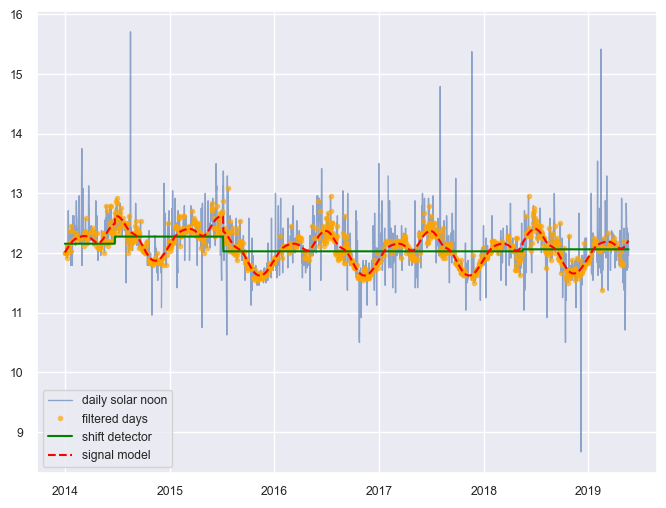

total time: 11.81 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.12s
Cleaning                   5.61s
Filtering/Summarizing      2.08s
    Data quality           0.33s
    Clear day detect       0.45s
    Clipping detect        0.16s
    Capacity change detect 1.13s

SS


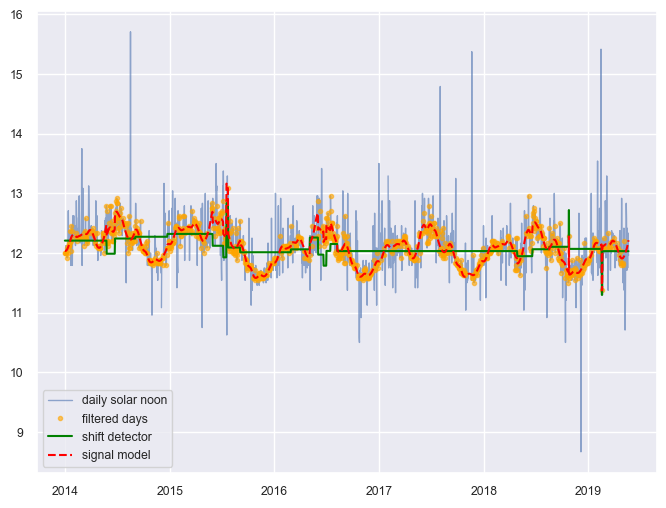

TACLC1036521
L2 norm
Timeshift: True


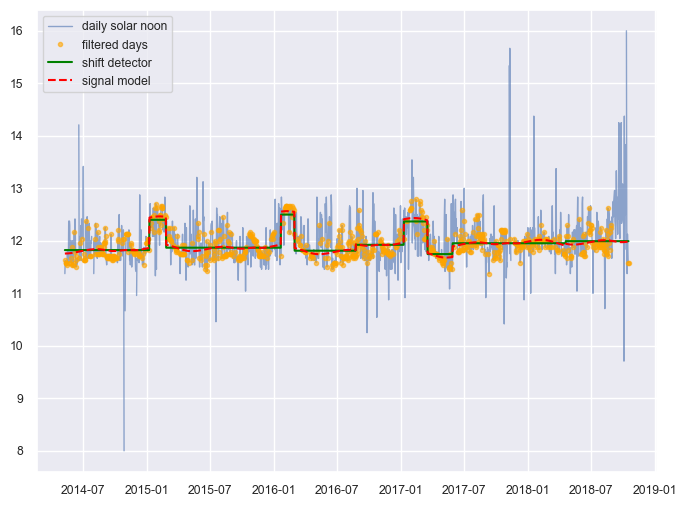

total time: 9.58 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.23s
Cleaning                   4.62s
Filtering/Summarizing      1.73s
    Data quality           0.23s
    Clear day detect       0.45s
    Clipping detect        0.16s
    Capacity change detect 0.89s

SS


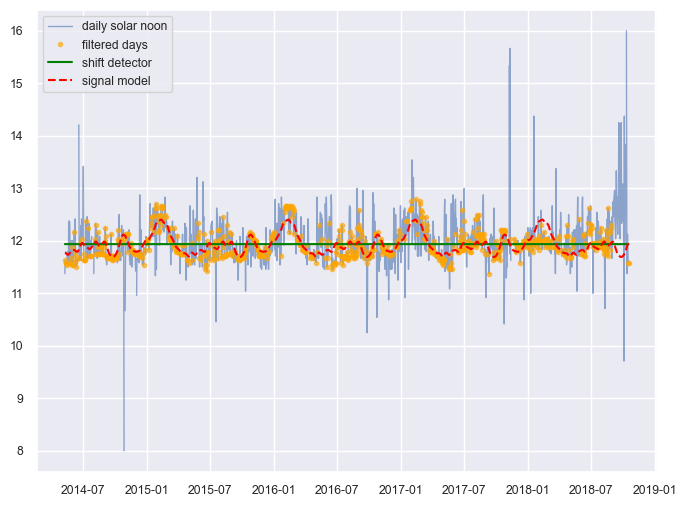

TABGC1044151
L2 norm
Timeshift: True


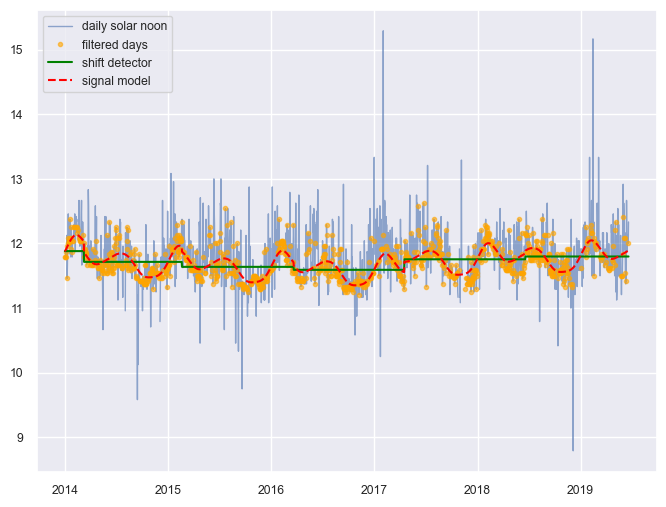

total time: 11.27 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.77s
Cleaning                   5.33s
Filtering/Summarizing      2.17s
    Data quality           0.28s
    Clear day detect       0.57s
    Clipping detect        0.14s
    Capacity change detect 1.18s

SS


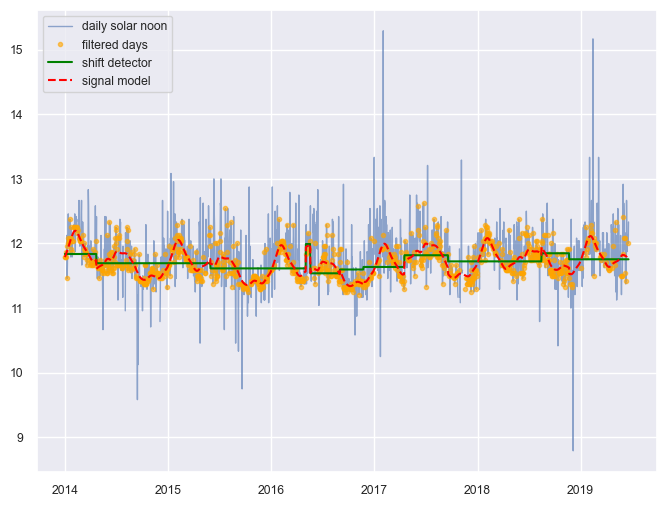

TABB01125140
L2 norm
Timeshift: True


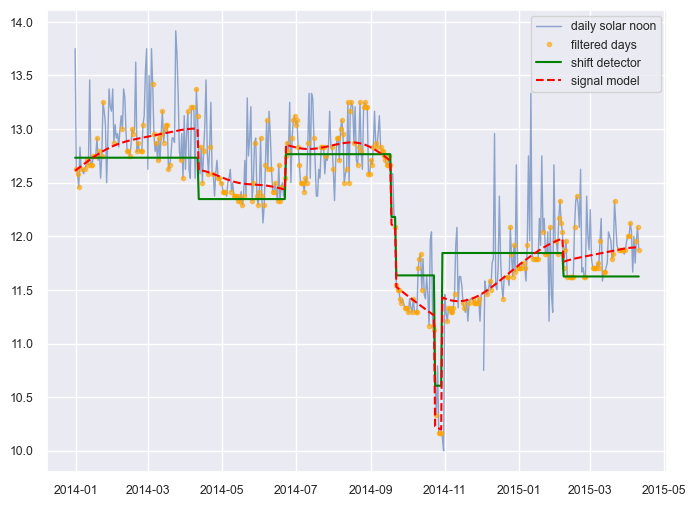

Fix time shift algorithm failed.
Error message: All-NaN slice encountered


total time: 12.83 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              1.64s
Cleaning                   10.43s
Filtering/Summarizing      0.76s
    Data quality           0.09s
    Clear day detect       0.15s
    Clipping detect        0.15s
    Capacity change detect 0.36s

SS


Traceback (most recent call last):
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/data_handler.py", line 429, in run_pipeline
    self.auto_fix_time_shifts(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/data_handler.py", line 964, in auto_fix_time_shifts
    self.time_shift_analysis.run(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/algorithms/time_shifts.py", line 73, in run
    hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
  File "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/solardatatools/algorithms/time_shifts.py", line 200, in optimize_c1
    best_ix = subset_ixs[np.nanargmin(hn[subset_ixs])]
  File "<__array_function__ internals>", line 180, in nanargmin
  File "/Users/smiskov/opt/anaconda3/envs/pvi-dev-sara/lib/python3.10/site-packages/numpy/lib/nanfunctions.py", line 553, in nanargmin
    raise ValueError("All-NaN slice encountered")
ValueError: All-NaN slice e

ValueError: x, y, and format string must not be None

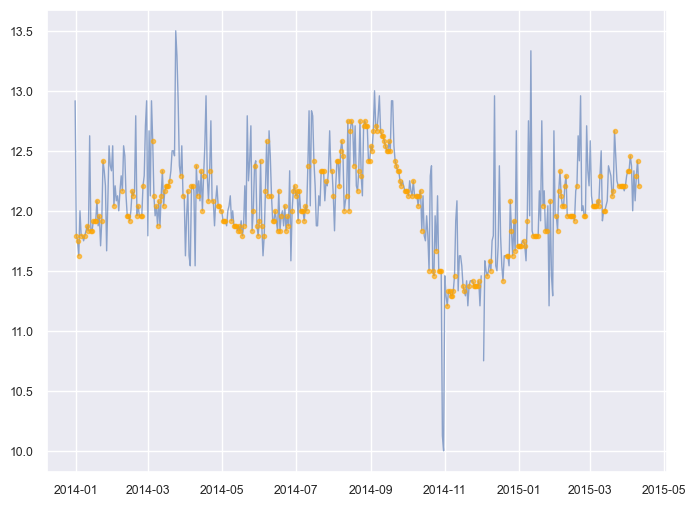

In [15]:
for path in true_list:
    print(path[23:-4])

    df = pd.read_csv(path)
    
    dh = DataHandler(df, convert_to_ts=True)
    dh.l2norm = True 
    dh.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=False, solver="MOSEK")
    print("L2 norm")
    print(f"Timeshift: {dh.time_shifts}")
    dh.plot_time_shift_analysis_results()
    plt.show()
    
    dh2 = DataHandler(df, convert_to_ts=True)
    dh2.l2norm = False 
    dh2.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=True, c2=results[f"{path}_weight_min_s1"], solver="MOSEK")
    print("SS")
    dh2.plot_time_shift_analysis_results()
    plt.show()

In [5]:
true_list = ['./cassandra/timeshifts/TABF01017766.csv', './cassandra/timeshifts/TACLC1036521.csv', './cassandra/timeshifts/TABGC1044151.csv', './cassandra/timeshifts/TABB01125140.csv', './cassandra/timeshifts/TABA01148025.csv', './cassandra/timeshifts/TACHC1020772.csv', './cassandra/timeshifts/TACHC1022171.csv', './cassandra/timeshifts/TACHC1022158.csv', './cassandra/timeshifts/TACIC1066981.csv', './cassandra/timeshifts/TAEAC1031314.csv', './cassandra/timeshifts/TADBC1077912.csv', './cassandra/timeshifts/TAAJ01021775.csv', './cassandra/timeshifts/TAEHC1001689.csv', './cassandra/timeshifts/TABD01110568.csv']

TABF01017766
L2 norm
Timeshift: True


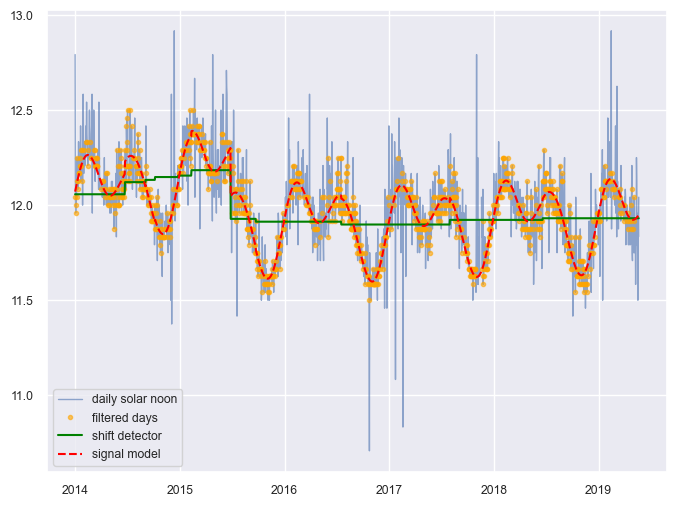

total time: 10.24 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.69s
Cleaning                   1.67s
Filtering/Summarizing      2.88s
    Data quality           0.43s
    Clear day detect       0.57s
    Clipping detect        0.23s
    Capacity change detect 1.64s

SS


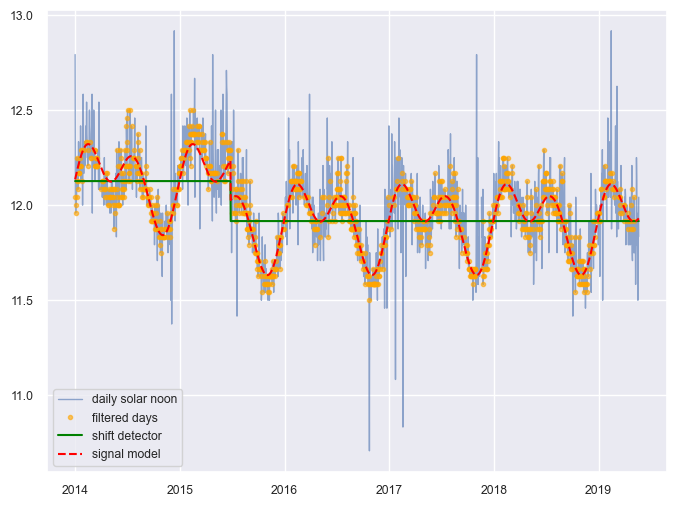

TACLC1036521
L2 norm
Timeshift: False


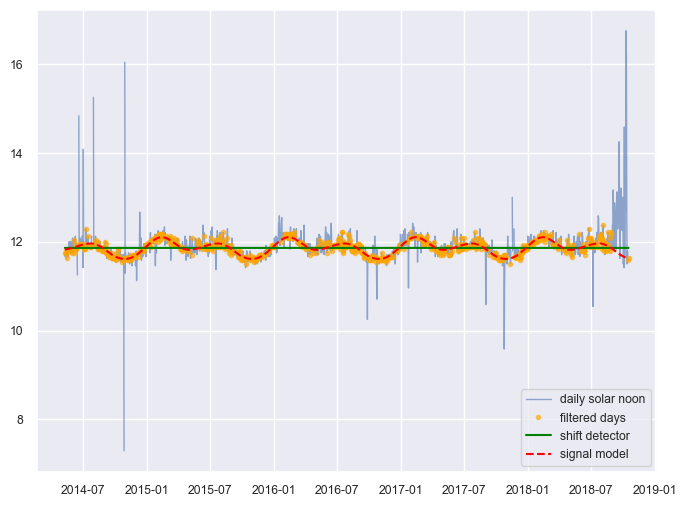

total time: 8.75 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.76s
Cleaning                   1.40s
Filtering/Summarizing      2.60s
    Data quality           0.35s
    Clear day detect       0.70s
    Clipping detect        0.23s
    Capacity change detect 1.32s

SS


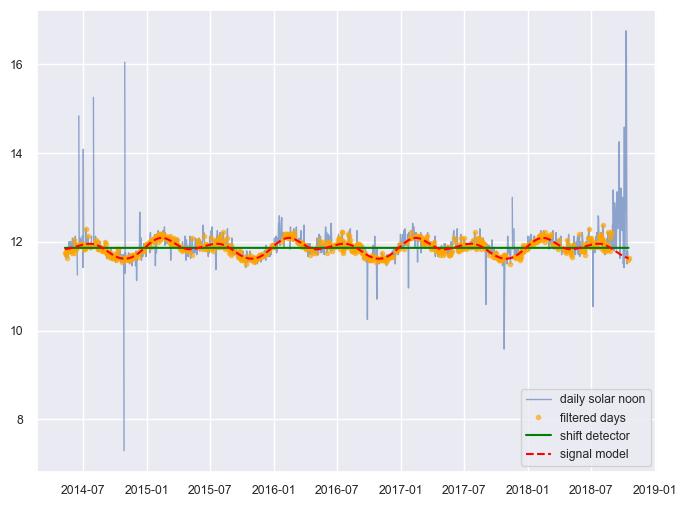

TABGC1044151
L2 norm
Timeshift: True


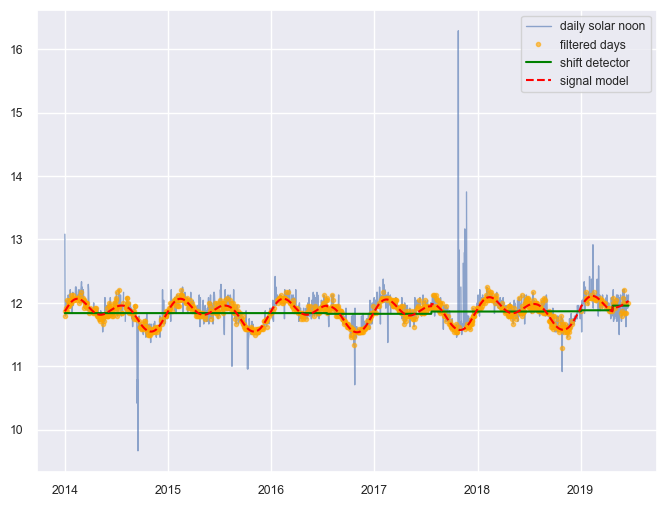

total time: 10.48 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.62s
Cleaning                   1.60s
Filtering/Summarizing      3.25s
    Data quality           0.44s
    Clear day detect       0.88s
    Clipping detect        0.22s
    Capacity change detect 1.71s

SS


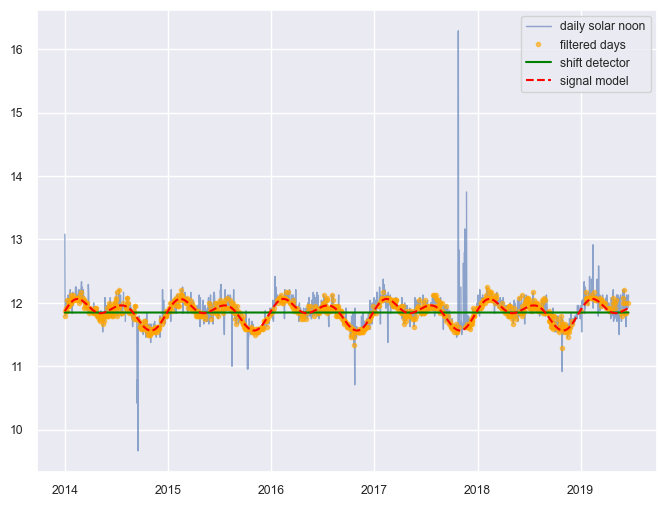

TABB01125140
L2 norm
Timeshift: True


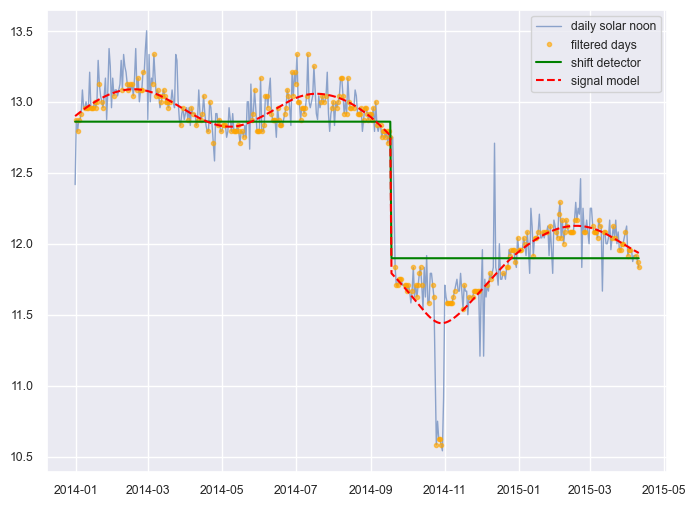

total time: 4.37 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.43s
Cleaning                   0.81s
Filtering/Summarizing      1.13s
    Data quality           0.13s
    Clear day detect       0.22s
    Clipping detect        0.22s
    Capacity change detect 0.55s

SS


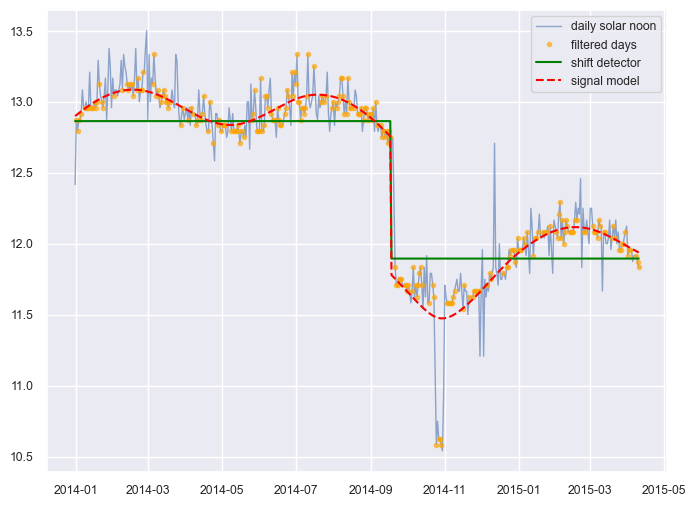

TABA01148025
L2 norm
Timeshift: True


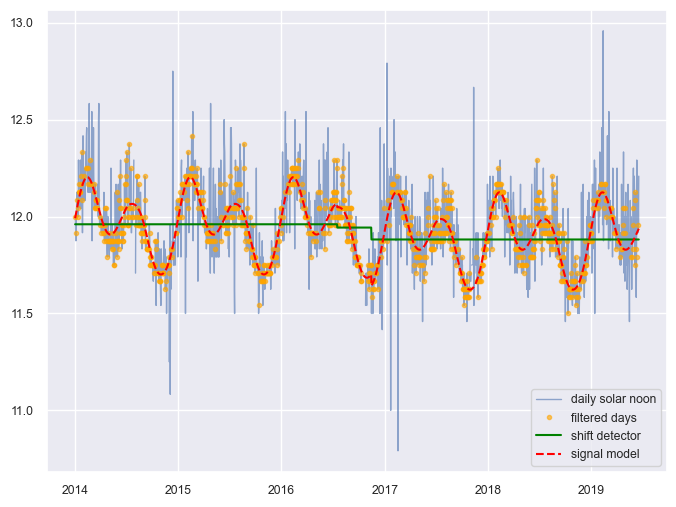

total time: 10.97 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.58s
Cleaning                   1.77s
Filtering/Summarizing      3.62s
    Data quality           0.45s
    Clear day detect       1.02s
    Clipping detect        0.24s
    Capacity change detect 1.91s

SS


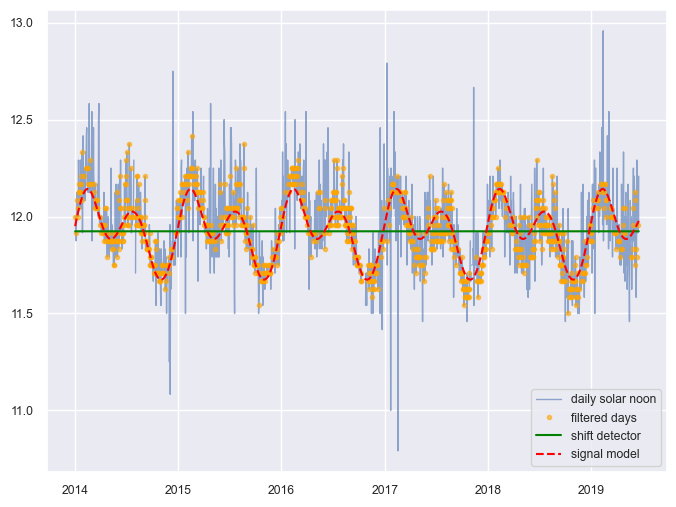

TACHC1020772
L2 norm
Timeshift: False


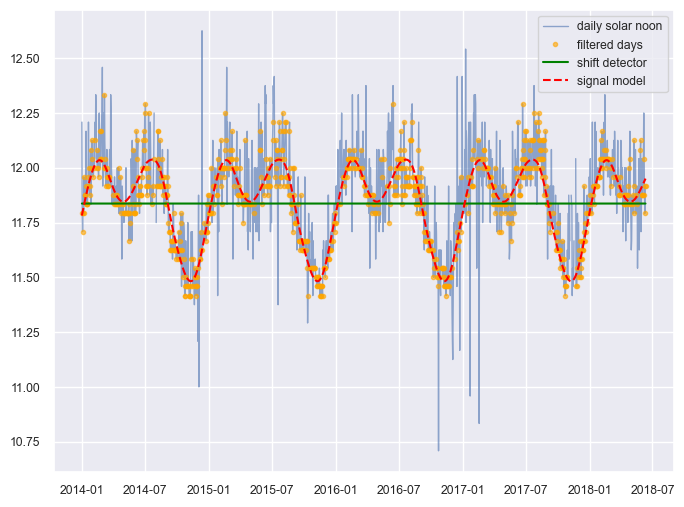

total time: 9.08 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.84s
Cleaning                   1.43s
Filtering/Summarizing      2.81s
    Data quality           0.36s
    Clear day detect       0.78s
    Clipping detect        0.22s
    Capacity change detect 1.44s

SS


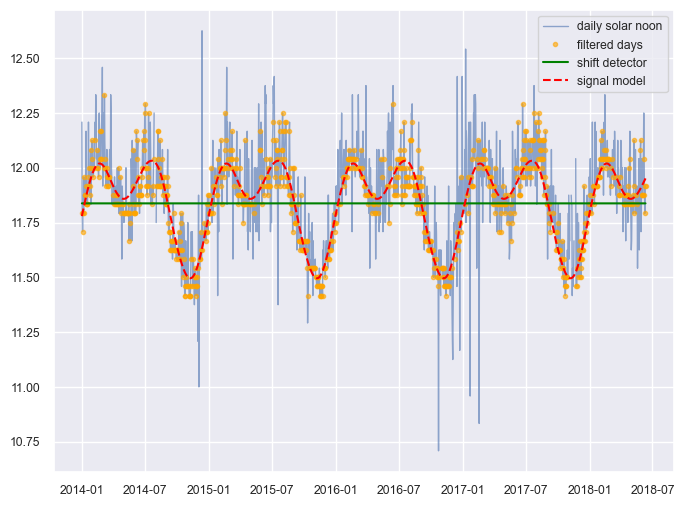

TACHC1022171
L2 norm
Timeshift: False


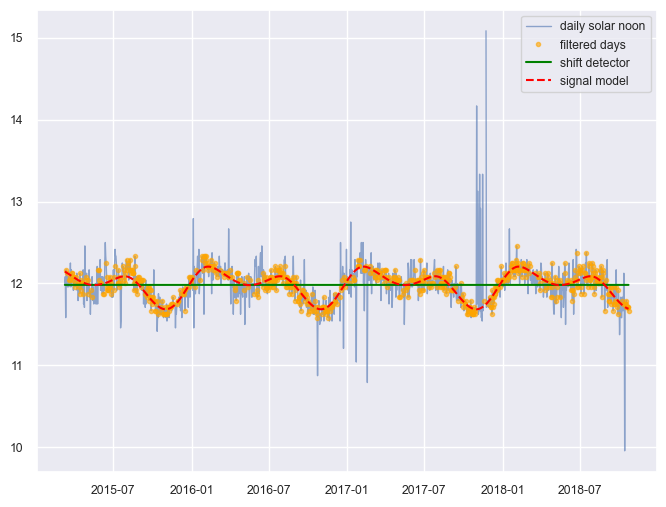

total time: 8.11 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.36s
Cleaning                   1.32s
Filtering/Summarizing      2.43s
    Data quality           0.29s
    Clear day detect       0.69s
    Clipping detect        0.23s
    Capacity change detect 1.22s

SS


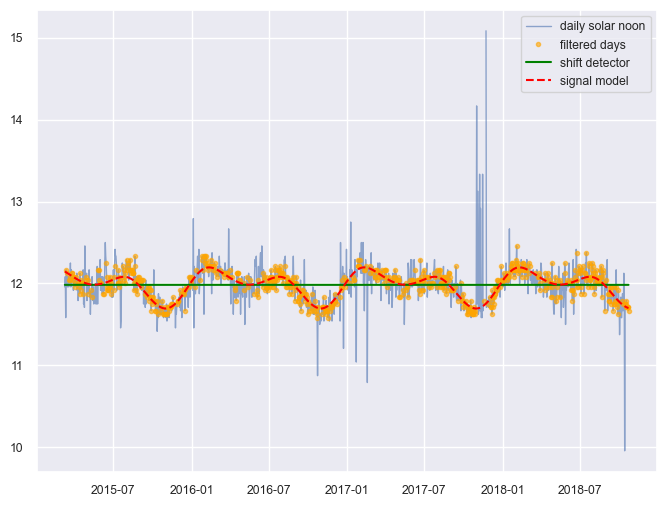

TACHC1022158
L2 norm
Timeshift: False


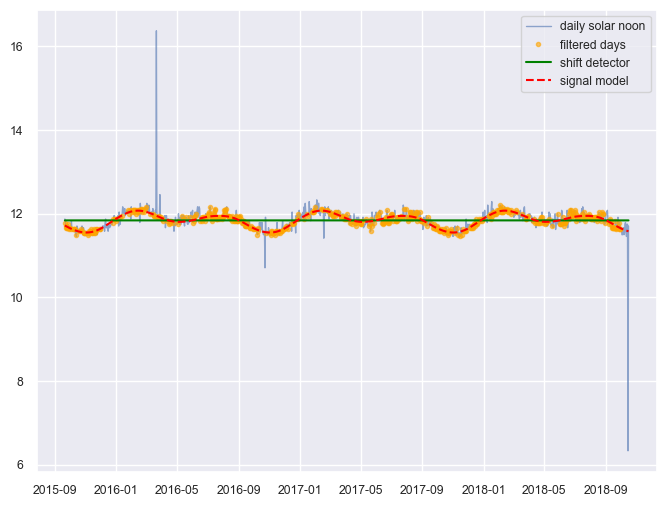

total time: 6.67 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.73s
Cleaning                   1.19s
Filtering/Summarizing      1.75s
    Data quality           0.26s
    Clear day detect       0.29s
    Clipping detect        0.22s
    Capacity change detect 0.99s

SS


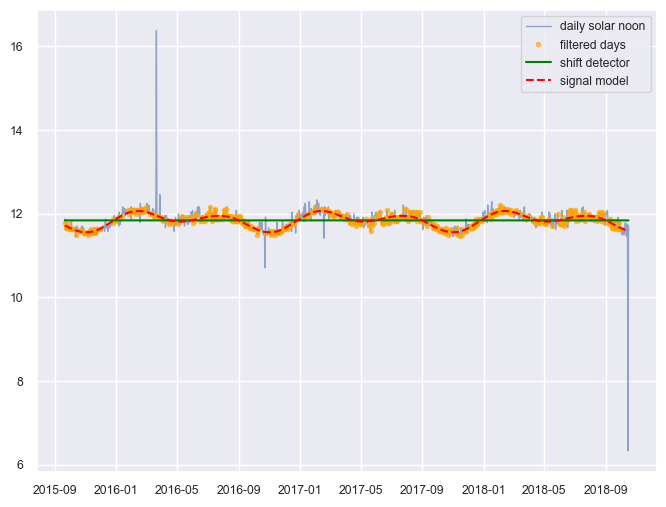

TACIC1066981
L2 norm
Timeshift: False


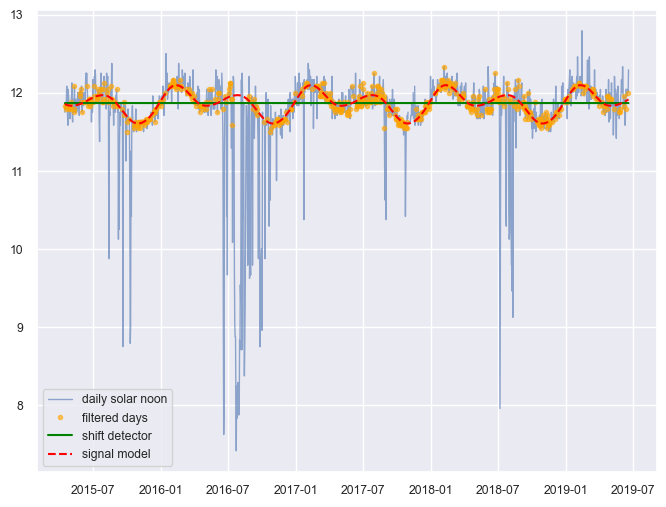

total time: 8.70 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.70s
Cleaning                   1.36s
Filtering/Summarizing      2.64s
    Data quality           0.34s
    Clear day detect       0.81s
    Clipping detect        0.22s
    Capacity change detect 1.27s

SS


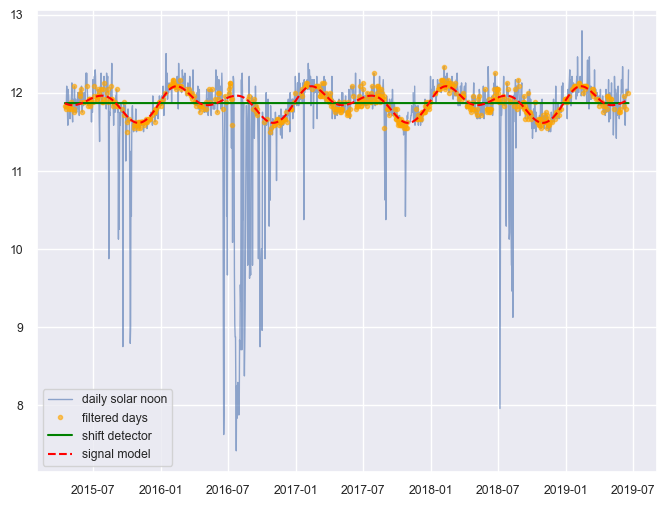

TAEAC1031314
L2 norm
Timeshift: False


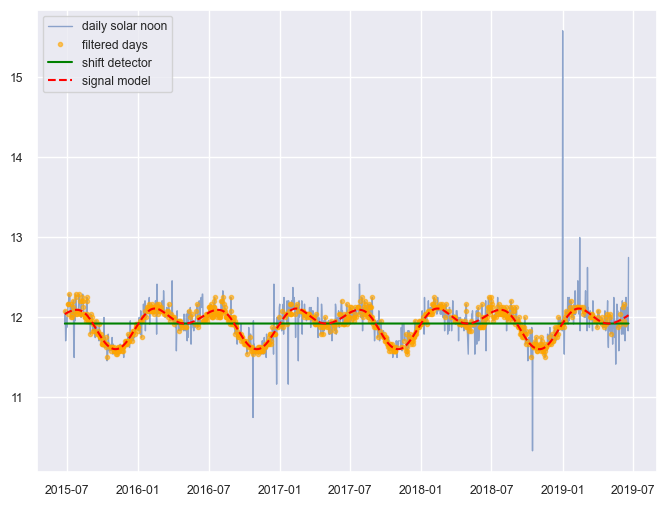

total time: 8.43 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.49s
Cleaning                   1.38s
Filtering/Summarizing      2.56s
    Data quality           0.33s
    Clear day detect       0.80s
    Clipping detect        0.22s
    Capacity change detect 1.21s

SS


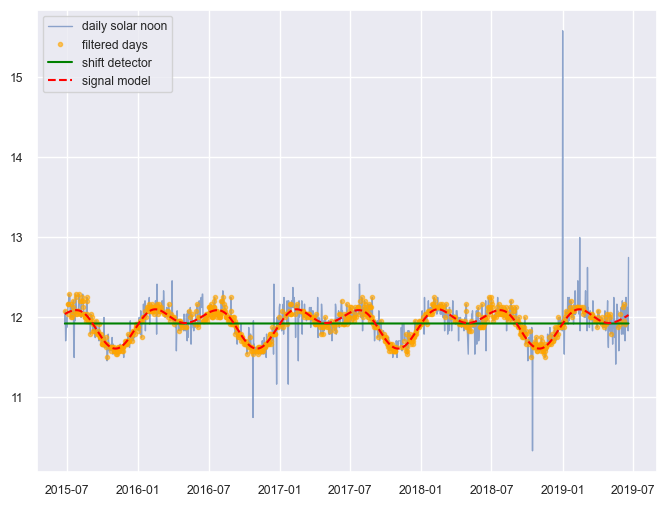

TADBC1077912
L2 norm
Timeshift: False


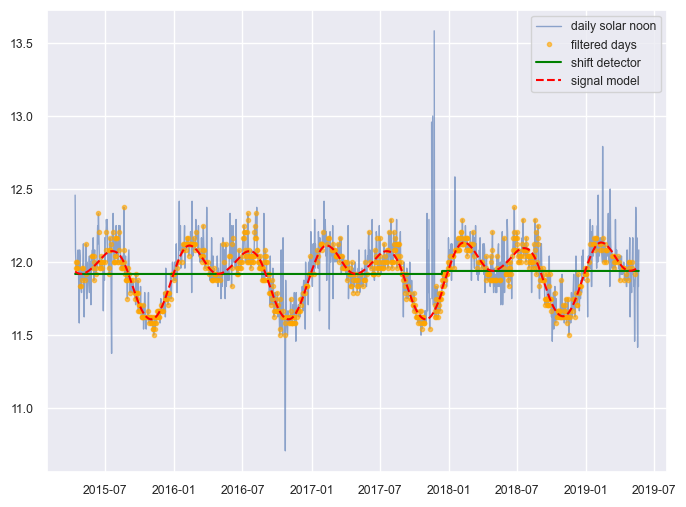

total time: 8.58 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.50s
Cleaning                   1.43s
Filtering/Summarizing      2.65s
    Data quality           0.34s
    Clear day detect       0.86s
    Clipping detect        0.21s
    Capacity change detect 1.23s

SS


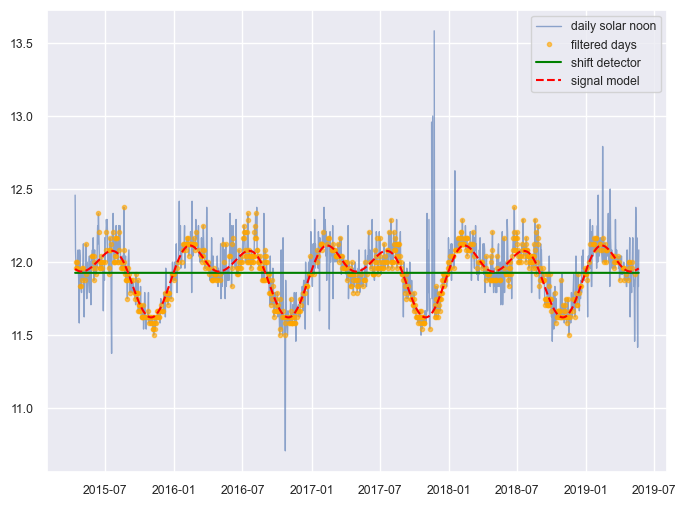

TAAJ01021775
L2 norm
Timeshift: True


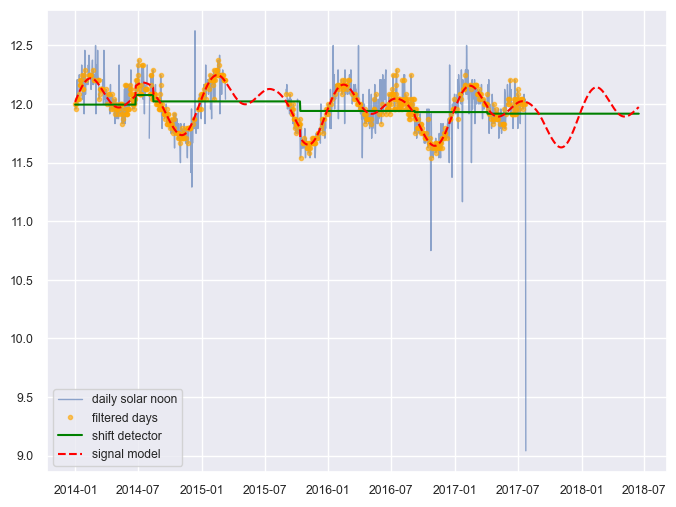

total time: 8.38 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              4.38s
Cleaning                   1.33s
Filtering/Summarizing      2.67s
    Data quality           0.31s
    Clear day detect       1.04s
    Clipping detect        0.22s
    Capacity change detect 1.10s

SS


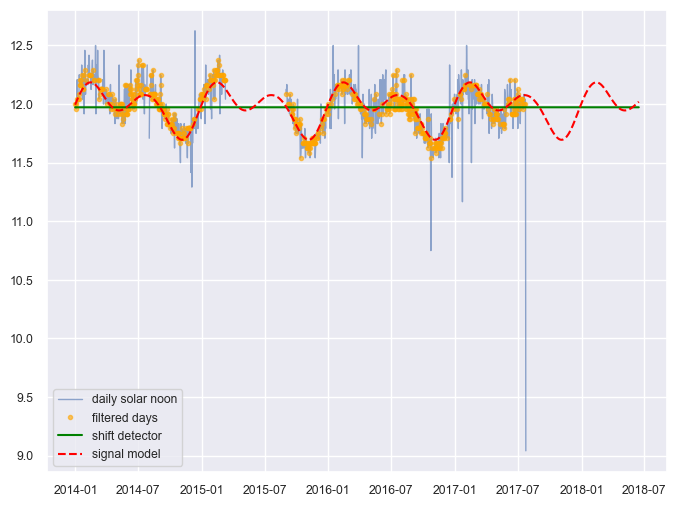

TAEHC1001689
L2 norm
Timeshift: False


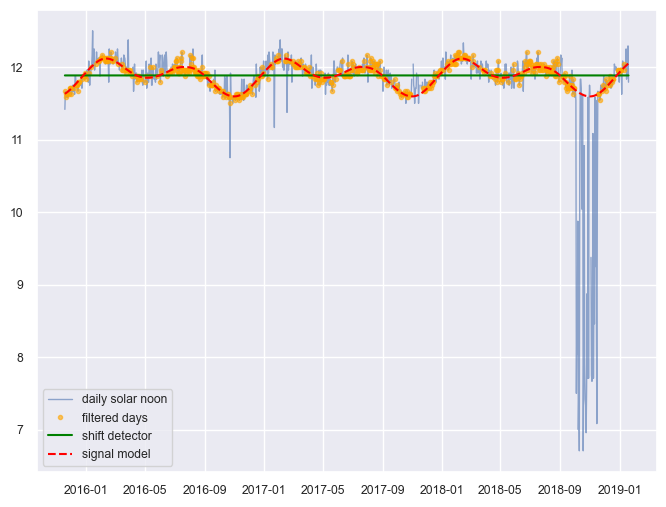

total time: 6.58 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.63s
Cleaning                   1.12s
Filtering/Summarizing      1.83s
    Data quality           0.26s
    Clear day detect       0.46s
    Clipping detect        0.22s
    Capacity change detect 0.89s

SS


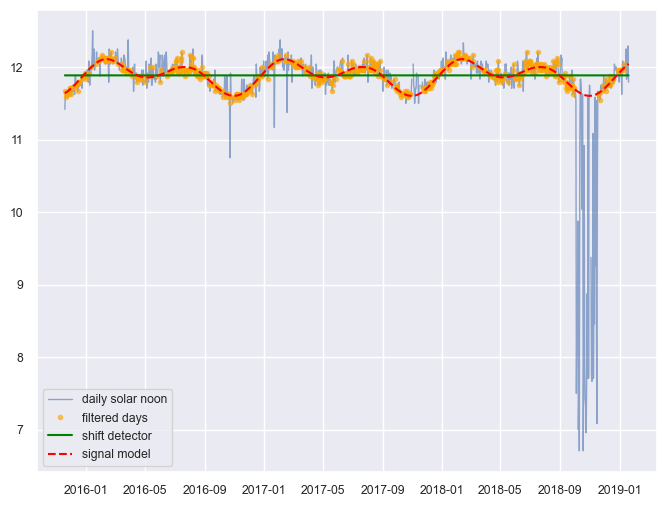

TABD01110568
L2 norm
Timeshift: True


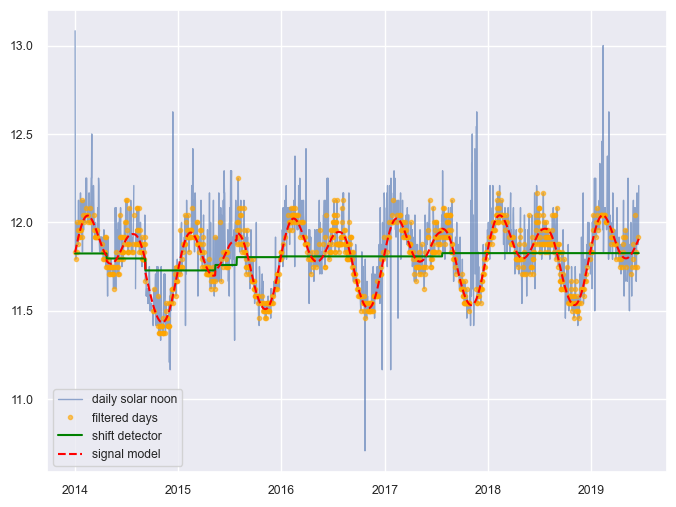

total time: 10.37 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              5.58s
Cleaning                   1.59s
Filtering/Summarizing      3.19s
    Data quality           0.43s
    Clear day detect       0.89s
    Clipping detect        0.24s
    Capacity change detect 1.64s

SS


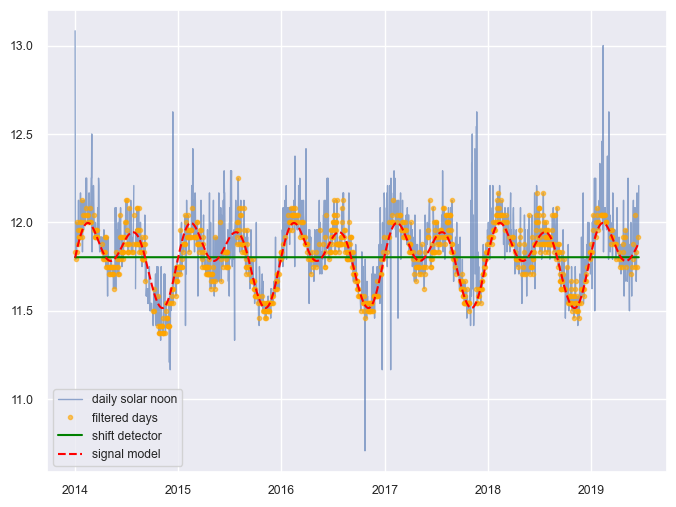

In [7]:
for path in true_list:
    print(path[23:-4])

    df = pd.read_csv(path)
    
    dh = DataHandler(df, convert_to_ts=True)
    dh.l2norm = True 
    dh.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=False, solver="MOSEK", daytime_threshold=0.01)
    print("L2 norm")
    print(f"Timeshift: {dh.time_shifts}")
    dh.plot_time_shift_analysis_results()
    plt.show()
    
    dh2 = DataHandler(df, convert_to_ts=True)
    dh2.l2norm = False 
    dh2.run_pipeline(power_col=dh.keys[0][-1], fix_shifts=True, verbose=True, c1=50, c2=1e5, solver="MOSEK", daytime_threshold=0.01)
    print("SS")
    dh2.plot_time_shift_analysis_results()
    plt.show()